# Import Dependencies

In [1]:
# Initial imports.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initial Trial with csv files

In [2]:
# from google.colab import files 
# uploaded = files.upload()

In [3]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['ml_BattingFielding.csv']))
# df.head()
# # Dataset is now stored in a Pandas Dataframe

# Database Connection

In [4]:
# dependencies
import psycopg2
from config import config

In [5]:
# get parameters
params = config()

In [6]:
# connect to PostgreSQL database
conn = psycopg2.connect(**params)

# create a new cursor
cur = conn.cursor()

In [7]:
# funcion to create a pandas df given parameters of: 1. SQL query 2. database connection
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table

In [8]:
# trial with only 1 table
batting_df = create_pandas_table('SELECT * FROM "Batting"')
batting_df.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,AVG
0,aardsda01,331,4,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.000000
1,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,0.304998
2,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,0.228814
3,aasedo01,448,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0,1.0,0.095238


### Build batting and fielding dataframe

In [9]:
# build batting/fielding df for machine learning analysis with SQL JOIN  multiple tables
combined_df = create_pandas_table('SELECT h."playerID",h."inducted", b."R",b."H",b."2B",b."3B",b."HR",b."RBI",b."SB", \
                                   b."CS",b."BB",b."SO",b."IBB",b."SH",b."SF",b."GIDP",b."AVG",f."PO",f."A",f."E", \
                                   f."DP",a."award_count" \
                                   FROM "Hall_Of_Fame" AS h \
                                   INNER JOIN "Batting" as b ON (h."playerID" = b."playerID") \
                                   INNER JOIN "Fielding" as f ON (h."playerID" = f."playerID") \
                                   INNER JOIN "Awards" as a ON (h."playerID" = a."playerID")')
combined_df.head()

,playerID,inducted,R,H,2B,3B,HR,RBI,SB,CS,...,IBB,SH,SF,GIDP,AVG,PO,A,E,DP,award_count
0,aaronha01,Y,2174,3771,624,98,755,2297.0,240.0,73.0,...,293.0,21.0,121.0,328.0,0.304998,7436,429,144.0,218,16
1,abbotji01,N,0,2,0,0,0,3.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.095238,72,300,9.0,16,2
2,adamsba01,N,79,216,31,15,3,75.0,1.0,1.0,...,0.0,35.0,0.0,0.0,0.211973,58,648,17.0,17,2
3,ageeto01,N,558,999,170,27,130,433.0,167.0,81.0,...,26.0,21.0,15.0,99.0,0.255368,2371,53,61.0,18,3
4,akerja01,N,3,7,2,0,0,4.0,0.0,0.0,...,0.0,10.0,0.0,1.0,0.076087,65,167,8.0,20,1


In [10]:
# check shape of df
combined_df.shape

(751, 22)

In [11]:
# check for null values
combined_df.isnull().sum()

playerID       0
inducted       0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
CS             0
BB             0
SO             0
IBB            0
SH             0
SF             0
GIDP           0
AVG            5
PO             0
A              0
E              0
DP             0
award_count    0
dtype: int64

In [12]:
# drop the rows with null values
combined_df = combined_df.dropna(subset=['AVG'])

In [13]:
# double check df shape
combined_df.shape

(746, 22)

### Build pitching dataframe

In [14]:
# build pitching df for machine learning analysis with SQL JOIN multiple tables
pitching_df = create_pandas_table('SELECT h."playerID",h."inducted",p."W",p."L",p."CG",p."SHO",p."SV", \
                                    p."H_allowed",p."ER",p."HR_allowed",p."BB_allowed",p."StruckOut",p."BAOpp", \
                                    p."ERA",p."WP",p."HitBatsmen",p."BK",p."R_allowed",p."SH_allowed",p."SF_allowed", \
                                    p."GIDP_pitcher",a."award_count" \
                                    FROM "Hall_Of_Fame" AS h \
                                    INNER JOIN "Pitching" as p ON (h."playerID" = p."playerID") \
                                    INNER JOIN "Awards" as a ON (h."playerID" = a."playerID")')
pitching_df.head()

,playerID,inducted,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,...,BAOpp,ERA,WP,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count
0,abbotji01,N,87,108,31,6,0,1779,791,154,...,0.280364,4.496364,53,32.0,11,880,70.0,47.0,200.0,2
1,adamsba01,N,194,140,206,44,15,2841,917,68,...,0.256667,3.733684,26,47.0,2,1129,0.0,0.0,0.0,2
2,akerja01,N,47,45,0,0,123,679,272,64,...,0.253571,3.854286,13,40.0,0,312,32.0,12.0,19.0,1
3,alexape01,Y,373,208,437,90,32,4868,1476,164,...,0.253810,2.972381,39,70.0,1,1851,0.0,0.0,0.0,21
4,allenjo02,N,142,75,109,17,18,1849,813,104,...,0.244667,3.765333,68,38.0,5,924,0.0,0.0,0.0,4


In [15]:
# check shape of df
pitching_df.shape

(284, 22)

In [16]:
# check for null values
pitching_df.isnull().sum()

playerID         0
inducted         0
W                0
L                0
CG               0
SHO              0
SV               0
H_allowed        0
ER               0
HR_allowed       0
BB_allowed       0
StruckOut        0
BAOpp           14
ERA              2
WP               0
HitBatsmen       0
BK               0
R_allowed        0
SH_allowed       0
SF_allowed       0
GIDP_pitcher     0
award_count      0
dtype: int64

In [17]:
# drop the rows with null values
pitching_df = pitching_df.dropna(subset=['ERA','BAOpp'])

In [18]:
# double check df shape
pitching_df.shape

(268, 22)

# Machine Learning

In [19]:
# define which dataframe will be used in machine learning model
# e.g. pitching or batting/fielding

# COMMENT OUT WHICHEVER YOU DO NOT WANT TO RUN!

# df = combined_df

df = pitching_df


In [20]:
# test conditional to compare / identify df's (for use later in code)
if df.equals(pitching_df):
    print('Pitching')
if df.equals(combined_df):
    print('Batting/Fielding')

Pitching


In [21]:
# encode inducted column from Y/N to numeric 0/1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = df.copy()
df2['inducted'] = le.fit_transform(df2['inducted'])

In [22]:
# define input (X) and output (y) variables
# drop columns of unnecessary features in X 
# batting/fielding 1st iteration showed the following features contributed <3%:
# SF, CS, IBB, SB

y = df2["inducted"]
if df.equals(combined_df):
    X = df2.drop(columns=["inducted", "playerID", "SF", "CS", "IBB", "SB"])  # Batters/Fielders
if df.equals(pitching_df):
    X = df2.drop(columns=["inducted", "playerID"]) # Pitchers (smaller dataset, keep all features)

In [23]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [24]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [26]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [27]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [28]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,48,2
Actual 1,8,9


In [29]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [30]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,48,2
Actual 1,8,9


Accuracy Score : 0.8507462686567164
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        50
           1       0.82      0.53      0.64        17

    accuracy                           0.85        67
   macro avg       0.84      0.74      0.77        67
weighted avg       0.85      0.85      0.84        67



## Feature Importance

In [31]:
# Calculate feature importance in the Random Forest model & sort largest to smallest
importances = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances

[(0.15575208755072845, 'award_count'),
 (0.12845291425451377, 'W'),
 (0.08538131469964486, 'CG'),
 (0.08022778206815692, 'SHO'),
 (0.07318296699145867, 'StruckOut'),
 (0.05906577647672253, 'H_allowed'),
 (0.050821452079496406, 'BAOpp'),
 (0.04871427407915604, 'ERA'),
 (0.03985640650688726, 'L'),
 (0.038764373583864115, 'BB_allowed'),
 (0.038620507360993137, 'R_allowed'),
 (0.028388683384555958, 'ER'),
 (0.027617534393457814, 'SV'),
 (0.027579605172174077, 'BK'),
 (0.026827118239423756, 'HR_allowed'),
 (0.02485025147900669, 'HitBatsmen'),
 (0.024333171950096356, 'WP'),
 (0.014886386799834738, 'SH_allowed'),
 (0.013436650497930509, 'SF_allowed'),
 (0.013240742431897984, 'GIDP_pitcher')]

In [32]:
rf_model.feature_importances_.sum()

1.0

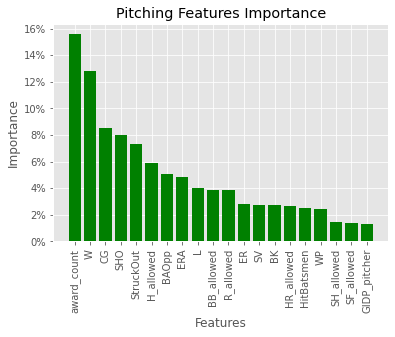

In [33]:
# Plot Importances in descending order
%matplotlib inline
plt.style.use('ggplot')
x = [lis[-1] for lis in importances]
y = [lis[0] for lis in importances]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
if df.equals(combined_df):
    plt.title('Batting/Fielding Features Importance')
if df.equals(pitching_df):
    plt.title('Pitching Features Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.xticks(x_pos,x,rotation=90,ha='center')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
if df.equals(combined_df):
    plt.savefig("analysis/Features_Combined.png")
if df.equals(pitching_df):
    plt.savefig("analysis/Features_Pitching.png")
plt.show()

## Investigate Predictions

In [34]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [35]:
print (X_test) #test dataset (without the actual outcome)
print (y_pred) #predicted values

       W    L   CG  SHO   SV  H_allowed    ER  HR_allowed  BB_allowed  \
81     1    0    0    0    0         13     4           0          14   
251  200  166  232   21   25       3417  1384         119         966   
116  253  154  260   36   33       3461  1188         227         725   
89   194  112   68   24    3       2564  1091         210         954   
282  111  109   79   20    1       1978   769         149         526   
..   ...  ...  ...  ...  ...        ...   ...         ...         ...   
120  303  166  100   37    2       3346  1513         411        1497   
248  170  161  158   28   35       2641   979         112        1046   
109   61   75    0    0  601        846   347         100         307   
250   69   60   69    8   20       1123   405          67         283   
56     0    0    0    0    0          3     1           0           1   

     StruckOut     BAOpp       ERA   WP  HitBatsmen  BK  R_allowed  \
81          11  0.085000  0.795000    0         1.0  

In [36]:
df2

,playerID,inducted,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,...,BAOpp,ERA,WP,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count
0,abbotji01,0,87,108,31,6,0,1779,791,154,...,0.280364,4.496364,53,32.0,11,880,70.0,47.0,200.0,2
1,adamsba01,0,194,140,206,44,15,2841,917,68,...,0.256667,3.733684,26,47.0,2,1129,0.0,0.0,0.0,2
2,akerja01,0,47,45,0,0,123,679,272,64,...,0.253571,3.854286,13,40.0,0,312,32.0,12.0,19.0,1
3,alexape01,1,373,208,437,90,32,4868,1476,164,...,0.253810,2.972381,39,70.0,1,1851,0.0,0.0,0.0,21
4,allenjo02,0,142,75,109,17,18,1849,813,104,...,0.244667,3.765333,68,38.0,5,924,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,wynnea01,1,300,244,290,49,15,4291,1796,338,...,0.247826,3.570870,51,64.0,2,2037,0.0,0.0,0.0,4
280,youngcy01,1,511,315,749,76,18,7092,2147,138,...,0.275000,2.713043,156,161.0,3,3167,0.0,0.0,0.0,3
281,zachrpa01,0,69,67,29,7,3,1147,461,88,...,0.264545,3.656364,19,21.0,10,529,57.0,43.0,79.0,1
282,zahnge01,0,111,109,79,20,1,1978,769,149,...,0.272357,4.449286,32,19.0,4,889,81.0,56.0,249.0,1


In [37]:
df2.columns

Index(['playerID', 'inducted', 'W', 'L', 'CG', 'SHO', 'SV', 'H_allowed', 'ER',
       'HR_allowed', 'BB_allowed', 'StruckOut', 'BAOpp', 'ERA', 'WP',
       'HitBatsmen', 'BK', 'R_allowed', 'SH_allowed', 'SF_allowed',
       'GIDP_pitcher', 'award_count'],
      dtype='object')

In [38]:
# create df with all data to investigate statistical trends
df3 = pd.merge(X_test, df2[["inducted","playerID"]], how="inner", left_index=True, right_index=True)

if df.equals(combined_df):
    # This one is specific to Batting/Fielding!!!
    df3 = df3[['playerID','R','H','2B','3B','HR','RBI','BB','SO','SH','GIDP','AVG','PO','A','E','DP','award_count','inducted']]
    
if df.equals(pitching_df):
    # This one is specific to Pitching
    df3 = df3[['playerID','W','L','CG','SHO','SV','H_allowed','ER','HR_allowed','BB_allowed','StruckOut','BAOpp','ERA','WP','HitBatsmen','BK','R_allowed','SH_allowed','SF_allowed','GIDP_pitcher','award_count','inducted']]
    
df3["predicted"] = y_pred   
df3

,playerID,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,BB_allowed,...,WP,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count,inducted,predicted
81,foxxji01,1,0,0,0,0,13,4,0,14,...,0,1.0,0,4,0.0,0.0,0.0,22,1,1
251,uhlege01,200,166,232,21,25,3417,1384,119,966,...,55,113.0,5,1635,0.0,0.0,0.0,5,0,0
116,hubbeca01,253,154,260,36,33,3461,1188,227,725,...,53,53.0,1,1380,0.0,0.0,0.0,22,1,1
89,goodedw01,194,112,68,24,3,2564,1091,210,954,...,76,78.0,33,1198,84.0,68.0,197.0,6,0,0
282,zahnge01,111,109,79,20,1,1978,769,149,526,...,32,19.0,4,889,81.0,56.0,249.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,johnsra05,303,166,100,37,2,3346,1513,411,1497,...,109,190.0,33,1703,131.0,89.0,251.0,13,1,1
248,troutdi01,170,161,158,28,35,2641,979,112,1046,...,50,34.0,7,1166,0.0,0.0,0.0,3,0,0
109,hoffmtr01,61,75,0,0,601,846,347,100,307,...,49,9.0,0,378,32.0,30.0,60.0,8,1,0
250,turneji01,69,60,69,8,20,1123,405,67,283,...,6,10.0,0,482,0.0,0.0,0.0,2,0,0


In [39]:
# Append dataframe with column comparing actual inducted to predicted accuracy.
df3['Accuracy'] = np.where(df3['inducted'] == df3['predicted'], 'Accurate', 'Inaccurate')
df3.head()

,playerID,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,BB_allowed,...,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count,inducted,predicted,Accuracy
81,foxxji01,1,0,0,0,0,13,4,0,14,...,1.0,0,4,0.0,0.0,0.0,22,1,1,Accurate
251,uhlege01,200,166,232,21,25,3417,1384,119,966,...,113.0,5,1635,0.0,0.0,0.0,5,0,0,Accurate
116,hubbeca01,253,154,260,36,33,3461,1188,227,725,...,53.0,1,1380,0.0,0.0,0.0,22,1,1,Accurate
89,goodedw01,194,112,68,24,3,2564,1091,210,954,...,78.0,33,1198,84.0,68.0,197.0,6,0,0,Accurate
282,zahnge01,111,109,79,20,1,1978,769,149,526,...,19.0,4,889,81.0,56.0,249.0,1,0,0,Accurate


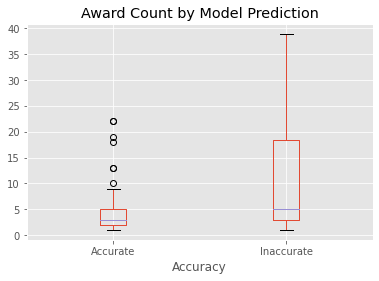

In [40]:
# Create boxplot comparing award count data of accurately predicted outcomes versus inaccurately predicted outcomes. 

df3.boxplot(column='award_count', by='Accuracy')
title_boxplot = 'Award Count by Model Prediction'
plt.title(title_boxplot)
plt.suptitle('') 
plt.savefig("analysis/AwardCountBoxplotbyPred.png")
plt.show()

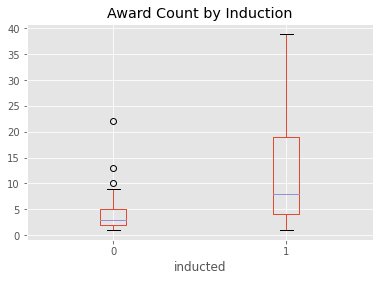

In [41]:
# Create boxplot comparing award count data of non-inductees(0) vs inductees(1). 
df3.boxplot(column='award_count', by='inducted')
title_boxplot = 'Award Count by Induction'
plt.title(title_boxplot)
plt.suptitle('') 
plt.savefig("analysis/AwardCountBoxplotbyInd.png")
plt.show()

In [42]:
# Create boxplot comparing runs data of accurately predicted outcomes versus inaccurately predicted outcomes. 
if df.equals(combined_df):
    df3.boxplot(column='R', by='Accuracy')
    title_boxplot = 'Runs Count by Model Prediction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/RunsBoxplotbyPred.png")
    plt.show()

In [43]:
# Create boxplot comparing runs count data of non-inductees(0) vs inductees(1). 
if df.equals(combined_df):
    df3.boxplot(column='R', by='inducted')
    title_boxplot = 'Runs Count by Induction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/RunsBoxplotbyInd.png")
    plt.show()

In [44]:
# Create boxplot comparing batting average data of accurately predicted outcomes versus inaccurately predicted outcomes. 
if df.equals(combined_df):
    df3.boxplot(column='AVG', by='Accuracy')
    title_boxplot = 'Batting Average by Model Prediction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/BattingAvgBoxplotbyPred.png")
    plt.show()

In [45]:
# Create boxplot comparing batting average data of non-inductees(0) vs inductees(1). 
if df.equals(combined_df):
    df3.boxplot(column='AVG', by='inducted')
    title_boxplot = 'Batting Average by Induction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/BattingAvgBoxplotbyInd.png")
    plt.show()

In [46]:
# Create boxplot comparing hits data of accurately predicted outcomes versus inaccurately predicted outcomes. 
if df.equals(combined_df):
    df3.boxplot(column='H', by='Accuracy')
    title_boxplot = 'Hits Count by Model Prediction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/HitsBoxplotbyPred.png")
    plt.show()

In [47]:
# Create boxplot comparing hits data of non-inductees(0) vs inductees(1). 
if df.equals(combined_df):
    df3.boxplot(column='H', by='inducted')
    title_boxplot = 'Hits by Induction'
    plt.title(title_boxplot)
    plt.suptitle('') 
    plt.savefig("analysis/HitsBoxplotbyInd.png")
    plt.show()

In [48]:
# Show mean data for each feature grouped by accuracy of prediction.
mean_summary_pred = df3.groupby('predicted').mean()
mean_summary_pred

,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,BB_allowed,StruckOut,...,ERA,WP,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count,inducted
predicted,,,,,,,,,,,,,,,,,,,,,
0,128.642857,105.339286,87.464286,16.642857,50.214286,1963.785714,797.928571,149.339286,668.196429,1122.892857,...,4.214591,48.767857,39.160714,6.767857,909.392857,40.535714,28.767857,76.285714,4.714286,0.142857
1,221.181818,153.090909,182.181818,33.454545,14.181818,3001.454545,1176.000000,236.000000,1052.272727,2205.727273,...,2.798694,60.272727,77.909091,8.272727,1348.181818,22.727273,17.454545,52.727273,12.272727,0.818182


In [49]:
if df.equals(combined_df):
    mean_summary_pred.to_csv("Scorecard_Batters.csv")
if df.equals(pitching_df):
    mean_summary_pred.to_csv("Scorecard_Pitchers.csv")


In [50]:
#perform a prediction
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
batting_prediction = [600,1500,500,100, 200, 1300, 400, 500, 100, 40, 0.3, 4000, 140, 80, 30, 20]
pitching_prediction = [303,166,100,37,2,3346,1513,411,1497,4875,0.225166667,3.480833333,109,190,33,1703,131,89,251,13]

# Batting/Fielding Prediction (COMMENT OUT IF USING PITCHING)
if df.equals(combined_df):
    prediction = clf.predict([batting_prediction])
if df.equals(pitching_df):
    prediction = clf.predict([pitching_prediction])

print ('Predicted Result: ', prediction)

Predicted Result:  [1]


# Build Interactive User Input

In [51]:
import tkinter as tk

## Batting / Fielding Input

In [52]:
if df.equals(combined_df):
    # tkinter GUI
    root= tk.Tk()
    root.title("Batting/Fielding")

    canvas1 = tk.Canvas(root, width = 500, height = 1400)
    canvas1.pack()

    # R input
    label1 = tk.Label(root, text='R:')
    canvas1.create_window(200, 100, window=label1)

    entry1 = tk.Entry (root)
    canvas1.create_window(270, 100, window=entry1)

    # H input
    label2 = tk.Label(root, text='H:')
    canvas1.create_window(200, 120, window=label2)

    entry2 = tk.Entry (root)
    canvas1.create_window(270, 120, window=entry2)

    # 2B input
    label3 = tk.Label(root, text='2B: ')
    canvas1.create_window(200, 140, window=label3)

    entry3 = tk.Entry (root)
    canvas1.create_window(270, 140, window=entry3)

    # 3B input
    label4 = tk.Label(root, text='3B:  ')
    canvas1.create_window(200, 160, window=label4)

    entry4 = tk.Entry (root)
    canvas1.create_window(270, 160, window=entry4)

    # HR input
    label5 = tk.Label(root, text='HR:  ')
    canvas1.create_window(200, 180, window=label5)

    entry5 = tk.Entry (root)
    canvas1.create_window(270, 180, window=entry5)

    # RBI input
    label6 = tk.Label(root, text='RBI:  ')
    canvas1.create_window(200, 200, window=label6)

    entry6 = tk.Entry (root)
    canvas1.create_window(270, 200, window=entry6)

    # BB input
    label7 = tk.Label(root, text='BB:  ')
    canvas1.create_window(200, 220, window=label7)

    entry7 = tk.Entry (root)
    canvas1.create_window(270, 220, window=entry7)

    # SO input
    label8 = tk.Label(root, text='SO:  ')
    canvas1.create_window(200, 240, window=label8)

    entry8 = tk.Entry (root)
    canvas1.create_window(270, 240, window=entry8)

    # SH input
    label9 = tk.Label(root, text='SH:  ')
    canvas1.create_window(200, 260, window=label9)

    entry9 = tk.Entry (root)
    canvas1.create_window(270, 260, window=entry9)

    # GIDP input
    label10 = tk.Label(root, text='GIDP:     ')
    canvas1.create_window(200, 280, window=label10)

    entry10 = tk.Entry (root)
    canvas1.create_window(270, 280, window=entry10)

    # AVG input
    label11 = tk.Label(root, text='AVG:    ')
    canvas1.create_window(200, 300, window=label11)

    entry11 = tk.Entry (root)
    canvas1.create_window(270, 300, window=entry11)

    # PO input
    label12 = tk.Label(root, text='PO:  ')
    canvas1.create_window(200, 320, window=label12)

    entry12 = tk.Entry (root)
    canvas1.create_window(270, 320, window=entry12)

    # A input
    label13 = tk.Label(root, text='A:  ')
    canvas1.create_window(200, 340, window=label13)

    entry13 = tk.Entry (root)
    canvas1.create_window(270, 340, window=entry13)

    # E input
    label14 = tk.Label(root, text='E:  ')
    canvas1.create_window(200, 360, window=label14)

    entry14 = tk.Entry (root)
    canvas1.create_window(270, 360, window=entry14)

    # DP input
    label15 = tk.Label(root, text='DP:  ')
    canvas1.create_window(200, 380, window=label15)

    entry15 = tk.Entry (root)
    canvas1.create_window(270, 380, window=entry15)

    # award_count input
    label16 = tk.Label(root, text='award_count:         ')
    canvas1.create_window(180, 400, window=label16)

    entry16 = tk.Entry (root)
    canvas1.create_window(270, 400, window=entry16)

    # # inducted input
    # label17 = tk.Label(root, text='inducted:  ')
    # canvas1.create_window(420, 420, window=label17)

    # entry17 = tk.Entry (root)
    # canvas1.create_window(270, 420, window=entry17)


    def values(): 
        global R
        R = float(entry1.get()) 

        global H
        H = float(entry2.get()) 

        global Double
        Double = float(entry3.get()) 

        global Triple
        Triple = float(entry4.get())

        global HR
        HR = float(entry5.get())

        global RBI
        RBI = float(entry6.get())

        global BB
        BB = float(entry7.get())

        global SO
        SO = float(entry8.get()) 

        global SH
        SH = float(entry9.get())

        global GIDP
        GIDP = float(entry10.get())

        global AVG
        AVG = float(entry11.get()) 

        global PO
        PO = float(entry12.get())

        global A
        A = float(entry13.get())

        global E
        E = float(entry14.get())

        global DP
        DP = float(entry15.get()) 

        global award_count
        award_count = float(entry16.get())

    #     global inducted
    #     inducted = float(entry17.get())           

        Prediction_result  = ('  Predicted Result: ', clf.predict([[R, H, Double, Triple, HR, RBI, BB, SO, SH, GIDP, AVG, PO, A, E, DP, award_count ]]))
        label_Prediction = tk.Label(root, text= Prediction_result, bg='sky blue')
        canvas1.create_window(270, 480, window=label_Prediction)

    button1 = tk.Button (root, text='      Predict      ',command=values, bg='green', fg='white', font=11)
    canvas1.create_window(270, 440, window=button1)

    root.mainloop()


## Pitching Input

In [53]:
if df.equals(pitching_df):
    # tkinter GUI
    root= tk.Tk()
    root.title("Pitching")

    canvas1 = tk.Canvas(root, width = 500, height = 2000)
    canvas1.pack()

    # W input
    label1 = tk.Label(root, text='W:')
    canvas1.create_window(200, 100, window=label1)

    entry1 = tk.Entry (root)
    canvas1.create_window(270, 100, window=entry1)

    # L input
    label2 = tk.Label(root, text='L:')
    canvas1.create_window(200, 120, window=label2)

    entry2 = tk.Entry (root)
    canvas1.create_window(270, 120, window=entry2)

    # CG input
    label3 = tk.Label(root, text='CG: ')
    canvas1.create_window(200, 140, window=label3)

    entry3 = tk.Entry (root)
    canvas1.create_window(270, 140, window=entry3)

    # SHO input\n",
    label4 = tk.Label(root, text='SHO:  ')
    canvas1.create_window(200, 160, window=label4)

    entry4 = tk.Entry (root)
    canvas1.create_window(270, 160, window=entry4)

    # SV input
    label5 = tk.Label(root, text='SV:  ')
    canvas1.create_window(200, 180, window=label5)

    entry5 = tk.Entry (root)
    canvas1.create_window(270, 180, window=entry5)

    # H_allowed input
    label6 = tk.Label(root, text='H_allowed:  ')
    canvas1.create_window(200, 200, window=label6)

    entry6 = tk.Entry (root)
    canvas1.create_window(270, 200, window=entry6)

    # ER input
    label7 = tk.Label(root, text='ER:  ')
    canvas1.create_window(200, 220, window=label7)

    entry7 = tk.Entry (root)
    canvas1.create_window(270, 220, window=entry7)

    # HR_allowed input
    label8 = tk.Label(root, text='HR_allowed:  ')
    canvas1.create_window(200, 240, window=label8)

    entry8 = tk.Entry (root)
    canvas1.create_window(270, 240, window=entry8)

    # BB_allowed input
    label9 = tk.Label(root, text='BB_allowed:  ')
    canvas1.create_window(200, 260, window=label9)

    entry9 = tk.Entry (root)
    canvas1.create_window(270, 260, window=entry9)

    # Struckout input
    label10 = tk.Label(root, text='Struckout:     ')
    canvas1.create_window(200, 280, window=label10)

    entry10 = tk.Entry (root)
    canvas1.create_window(270, 280, window=entry10)

    # BAOpp input
    label11 = tk.Label(root, text='BAOpp:    ')
    canvas1.create_window(200, 300, window=label11)

    entry11 = tk.Entry (root)
    canvas1.create_window(270, 300, window=entry11)

    # ERA input
    label12 = tk.Label(root, text='ERA:  ')
    canvas1.create_window(200, 320, window=label12)

    entry12 = tk.Entry (root)
    canvas1.create_window(270, 320, window=entry12)

    # WP input
    label13 = tk.Label(root, text='WP:  ')
    canvas1.create_window(200, 340, window=label13)

    entry13 = tk.Entry (root)
    canvas1.create_window(270, 340, window=entry13)

    # HitBatsmen input
    label14 = tk.Label(root, text='HitBatsmen:  ')
    canvas1.create_window(200, 360, window=label14)

    entry14 = tk.Entry (root)
    canvas1.create_window(270, 360, window=entry14)

    # BK input
    label15 = tk.Label(root, text='BK:  ')
    canvas1.create_window(200, 380, window=label15)

    entry15 = tk.Entry (root)
    canvas1.create_window(270, 380, window=entry15)

    # R_allowed input
    label16 = tk.Label(root, text='R_allowed:         ')
    canvas1.create_window(180, 400, window=label16)

    entry16 = tk.Entry (root)
    canvas1.create_window(270, 400, window=entry16)

    # SH_allowed input
    label17 = tk.Label(root, text='SH_allowed:         ')
    canvas1.create_window(180, 420, window=label17)

    entry17 = tk.Entry (root)
    canvas1.create_window(270, 420, window=entry17)

    # SF_allowed input
    label18 = tk.Label(root, text='SF_allowed:         ')
    canvas1.create_window(180, 440, window=label18)

    entry18 = tk.Entry (root)
    canvas1.create_window(270, 440, window=entry18)

    # GIDP_pitcher input
    label19 = tk.Label(root, text='GIDP_pitcher:         ')
    canvas1.create_window(180, 460, window=label19)

    entry19 = tk.Entry (root)
    canvas1.create_window(270, 460, window=entry19)

    # award_count input
    label20 = tk.Label(root, text='award_count:         ')
    canvas1.create_window(180, 480, window=label20)

    entry20 = tk.Entry (root)
    canvas1.create_window(270, 480, window=entry20)

    # inducted input
    # label17 = tk.Label(root, text='inducted:  ')
    # canvas1.create_window(420, 420, window=label17)

    # entry17 = tk.Entry (root)
    # canvas1.create_window(270, 420, window=entry17)


    def values(): 
        global W
        W = float(entry1.get())

        global L
        L = float(entry2.get())

        global CG
        CG = float(entry3.get())

        global SHO
        SHO = float(entry4.get())

        global SV
        SV = float(entry5.get())

        global H_allowed
        H_allowed = float(entry6.get())

        global ER
        ER = float(entry7.get())

        global HR_allowed
        HR_allowed = float(entry8.get())

        global BB_allowed
        BB_allowed = float(entry9.get()) 

        global Struckout
        Struckout = float(entry10.get())

        global BAOpp
        BAOpp = float(entry11.get())

        global ERA
        ERA = float(entry12.get()) 

        global WP
        WP = float(entry13.get())

        global HitBatsmen
        HitBatsmen = float(entry14.get())

        global BK
        BK = float(entry15.get())

        global R_allowed
        R_allowed = float(entry16.get()) 

        global SH_allowed
        SH_allowed = float(entry17.get())

        global SF_allowed
        SF_allowed = float(entry18.get())

        global GIDP_pitcher
        GIDP_pitcher = float(entry19.get())

        global award_count
        award_count = float(entry20.get())

    #     global inducted\n",
    #     inducted = float(entry17.get())           \n",

        Prediction_result  = ('  Predicted Result: ', clf.predict([[W, L, CG, SHO, SV, H_allowed, ER, HR_allowed, \
                                BB_allowed, Struckout, BAOpp, ERA, WP, HitBatsmen, BK, R_allowed, SH_allowed, SF_allowed, \
                                                                    GIDP_pitcher, award_count ]]))
        label_Prediction = tk.Label(root, text= Prediction_result, bg='sky blue')
        canvas1.create_window(270, 520, window=label_Prediction)

    button1 = tk.Button (root, text='      Predict      ',command=values, bg='green', fg='white', font=11)
    canvas1.create_window(270, 500, window=button1)

    root.mainloop()